# Solution of a trapezoidal dam by FEM using SolidsPy

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque and Universidad EAFIT.

This notebook is a modified and extended version of the [original one](https://nbviewer.org/github/AppliedMechanics-EAFIT/modelacion_computacional/blob/master/proyectos/presa/taller_presa_trapezoidal.ipynb) by Guarín-Zapara and Gómez in the   [SolidsPy repo](https://github.com/AppliedMechanics-EAFIT/SolidsPy).

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/EAFIT_solid_mechanics/blob/main/notebooks/trapezoidal_dam.ipynb).

> Note: Be aware that this notebook follows solid mechanics sign conventions → Tractions are positive, compressions are negative, and shear forces/stresses are positive when they act on the positive $x$-plane and point to the positive $y$-direction.

This notebook depends on:
* SolidsPy V1.0.16 [Guarín-Zapata et al. (2020)](https://doi.org/10.5281/zenodo.4029270)
* pygmsh V6.0.2 [Schlömer et al. (2019a)](https://doi.org/10.5281/zenodo.3541027)
* meshio V3.3.1 [Schlömer et al. (2019b)](https://doi.org/10.5281/zenodo.3584511)
* And other packages for general scientific programming in Python


## Setting up the environment

### Required modules and setup for plots

In [152]:
from IPython import get_ipython
if 'google.colab' in str(get_ipython()):
    from google.colab import output, files
    output.enable_custom_widget_manager()
    print('Running on CoLab. Installing the required modules...')
    !apt-get update -qq && apt-get install -y libglu1-mesa -y &> ~/apt-log.txt
    %pip install gmsh==4.10.5 &> ~/pip-log.txt
    %pip install meshio==3.3.1 &> ~/pip-log.txt
    %pip install pygmsh==6.0.2 &> ~/pip-log.txt
    %pip install solidspy==1.0.16 &> ~/pip-log.txt
    %pip install ipympl &> ~/pip-log.txt &> ~/pip-log.txt
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import meshio
from ipywidgets import widgets as wgt
import solidspy.preprocesor as pre
import solidspy.postprocesor as pos
import solidspy.assemutil as ass
import solidspy.solutil as sol
import solidspy.uelutil as uel
from IPython.display import display

%matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
html_setup = '<style> div.jupyter-widgets.widget-label {display: none;} </style>'


## Auxiliar fuctions

In [153]:
def locate_pts_line(physical_line, points , cells , cell_data):
    """
    Find the nodes located on a physical line and their coordinates.
    """
    lines = cells["line"]
    phy_line = cell_data["line"]["gmsh:physical"]
    id_carga = [cont for cont in range(len(phy_line))
                if phy_line[cont] == physical_line]
    nodes_line = lines[id_carga]
    nodes_line = nodes_line.flatten()
    nodes_line = list(set(nodes_line))
    line_x = points[nodes_line][:, 0]
    line_y = points[nodes_line][:, 1]
    return nodes_line, line_x, line_y

def dam_loading(cells, cell_data, phy_lin, nodes, P_y,  gamma_h, Hdam):
    """
    Impone cargas nodales que varían linealmente con intensidad máxima en la pata
    de la presa consistentes con presión hidriestática.
    """
    lines = cells["line"]
    phy_line = cell_data["line"]["gmsh:physical"]
    id_carga = [cont for cont in range(len(phy_line))
                if phy_line[cont] == phy_lin]
    nodes_carga = lines[id_carga]
    nodes_carga = nodes_carga.flatten()
    nodes_carga = list(set(nodes_carga))
    ncargas = len(nodes_carga)
    nodes_line, line_x, line_y = locate_pts_line(phy_lin, nodes , cells , cell_data)
    cargas = np.zeros((ncargas, 3))
    cargas[:, 0] = nodes_carga
    cargas[:, 1] = 0.5*gamma_h*(Hdam-line_y)*Hdam/ncargas
    cargas[:, 2] = P_y/ncargas
    return cargas


def body_forces(elements, nodes, neq, DME, force_x=None, force_y=None):
    """Compute nodal forces due to body"""
    if force_x is None:
        def force_x(x, y): return 0
    if force_y is None:
        def force_y(x, y): return 0
    force_vec = np.zeros((neq))
    nels = elements.shape[0]
    for el in range(nels):
        verts = nodes[elements[el, 3:], 1:3]
        centroid = (verts[0, :] + verts[1, :] + verts[2, :])/3
        area = 0.5 * np.linalg.det(np.column_stack((verts, np.ones(3))))
        floc = np.array([force_x(*centroid), force_y(*centroid),
                         force_x(*centroid), force_y(*centroid),
                         force_x(*centroid), force_y(*centroid)])
        floc = floc * area
        dme = DME[el, :6]
        for row in range(6):
            glob_row = dme[row]
            if glob_row != -1:
                force_vec[glob_row] = force_vec[glob_row] + floc[row]
    return force_vec

def force_y(x, y):
    """Body force due to self-weight"""
    return -2.3 * 9.8e3


## SolidsPy's inputs

### Reading the external mesh

In [171]:
if 'google.colab' in str(get_ipython()):
    file = files.upload()
    df = pd.read_excel(list(file.values())[0])
else:
    tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
    # file = askopenfilename()
    mesh = meshio.read(askopenfilename())

# mesh = meshio.read("mesh_trapez_dam.msh")
points = mesh.points  # Coordenadas de los nodos
cells = mesh.cells  # Diccionario con nodos para líneas y triángulos
point_data = mesh.point_data  # Datos para visualizar en gmsh
cell_data = mesh.cell_data  # Grupos físicos
field_data = mesh.field_data  # Datos para visualizar en gmsh


### Global inputs

In [172]:
# Geometry
H_p = 100.0  # altura de la presa [m]
A_c = 30.0  # ancho de la cresta [m]
gamma = 9.8e3  # peso unitario del agua [N/m3]

self_weight = False

# # Material properties
# elastic_mod = 1e6  # [N]


### Nodes

**Notes:**
- Global coordinates with origin in the bottom left corner of the truss, i.e., at node 2.
- For defining constraints, -1 means constrained, and 0 is unconstrained.

In [173]:
####
nodes_array = pre.node_writer(points, point_data)
nodes_array = pre.boundary_conditions(cells, cell_data, 2000, nodes_array, -1, 0)  # Restricción en X para puntos en línea física 2000
nodes_array = pre.boundary_conditions(cells, cell_data, 1000, nodes_array, 0, -1)  # Restricción en Y para puntos en línea física 1000
nodes = pd.DataFrame(data=nodes_array,
                     columns=['node_id', 'coord_x', 'coord_y',
                              'cons_x', 'cons_y'])
nodes


,node_id,coord_x,coord_y,cons_x,cons_y
0,0.0,-100.000000,-50.000000,0.0,-1.0
1,1.0,160.000000,-50.000000,0.0,-1.0
2,2.0,160.000000,0.000000,-1.0,0.0
3,3.0,60.000000,0.000000,0.0,0.0
4,4.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...
5796,5796.0,27.908933,97.994000,0.0,0.0
5797,5797.0,3.665801,90.857784,0.0,0.0
5798,5798.0,28.697458,97.511343,0.0,0.0
5799,5799.0,2.093234,96.998822,0.0,0.0


### Materials


In [174]:
mats = pd.DataFrame(
    {
    'mat_id': (100, 200),
    'elast_mod': (6000e9, 50e9),
    'poisson_rat': (0.2, 0.2)
    }
)
mats


,mat_id,elast_mod,poisson_rat
0,100,6.000000e+12,0.2
1,200,5.000000e+10,0.2


### Elements conectivity

In [175]:
nf, els1= pre.ele_writer(cells, cell_data, "triangle", 100, 3, 0, 0)  # Elementos para material "100" (roca)
nini = nf
nf, els2 = pre.ele_writer(cells, cell_data, "triangle", 200, 3, 1, nini)  # Elementos para material "200" (presa) desde el contador final del anterior
els_array = np.append(els1, els2, axis=0)  # Se concatenan los elementos de los dos materiales

elems = pd.DataFrame(data=els_array,
                     columns=['elem_id', 'elem_type', 'mat_profile',
                              'node_j', 'node_k', 'node_l'])

elems


,elem_id,elem_type,mat_profile,node_j,node_k,node_l
0,0,3,0,784,1012,1014
1,1,3,0,1012,1013,1014
2,2,3,0,1012,461,1013
3,3,3,0,1014,1013,785
4,4,3,0,474,1015,1017
...,...,...,...,...,...,...
11171,11171,3,1,5747,4207,3474
11172,11172,3,1,3191,5763,3638
11173,11173,3,1,5763,5800,3638
11174,11174,3,1,5763,3509,5800


### Loads

In [176]:
cargas = dam_loading(cells, cell_data, 3000, points, 0.0, gamma, H_p)
loads = pd.DataFrame(data=cargas, columns=['node_id', 'force_x', 'force_y'])
loads


,node_id,force_x,force_y
0,384.0,49883.270255,0.0
1,385.0,54896.967346,0.0
2,386.0,60102.077662,0.0
3,387.0,65307.187978,0.0
4,388.0,70711.021240,0.0
...,...,...,...
70,379.0,25907.470757,0.0
71,380.0,30559.199559,0.0
72,381.0,35210.928362,0.0
73,382.0,40040.250763,0.0


In [177]:
# Inputs to arrays
nodes = nodes.to_numpy()
mats = mats.to_numpy()[:, 1:]
elems = elems.to_numpy()
loads = loads.to_numpy()


## FEM procedure

### Global stiffness matrix

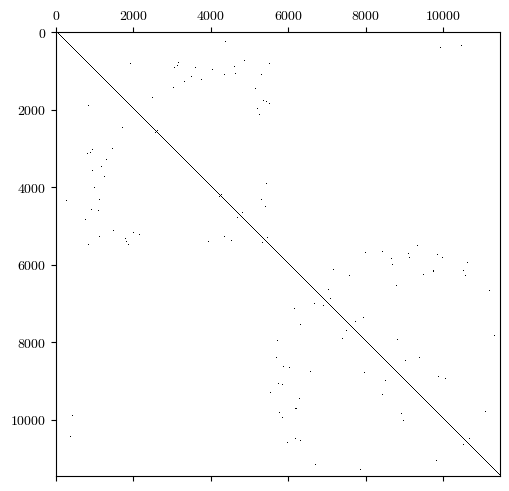

In [178]:
# Get the assembly operator, boundary conditions array and No. of active equations in the system
DME , IBC , neq = ass.DME(nodes, elems)
# Assemble the global unconstrained stiffness matrix
K_global = ass.assembler(elems, mats, nodes, neq, DME, sparse=False)

# Visualizing the global stiffness matrix
fig, ax = plt.subplots(ncols=1, nrows=1, layout='constrained')
ax.spy(K_global)
display(fig)


### Right-hand-side (rhs) vector of the equation to solve

In [179]:
if self_weight:
    force_vec = ass.loadasem(loads, IBC, neq) + \
        body_forces(elems, nodes, neq, DME , force_y=force_y)
else:
    force_vec = ass.loadasem(loads, IBC, neq)

print(force_vec)


[0. 0. 0. ... 0. 0. 0.]


### Solve the system of equations

In [180]:
# Solve a static problem [mat]{u_sol} = {rhs}
disp_ = sol.static_sol(K_global, force_vec)
# Complete the displacement vectors with imposed and computed values
disp = pos.complete_disp(IBC, nodes, disp_)
print(disp)


[[ 1.24693269e-07  0.00000000e+00]
 [ 1.18954034e-07  0.00000000e+00]
 [ 0.00000000e+00  3.48968950e-07]
 ...
 [ 3.38972891e-03 -7.05081232e-05]
 [ 3.38047966e-03  9.23565011e-04]
 [ 3.34855249e-03  2.79404893e-04]]


## Post-processing

### Calcute fields

In [181]:
# Averaged strains and stresses at nodes
strain, stress = pos.strain_nodes(nodes, elems, mats, disp)
# Compute the principal directions of a tensor field
eigs1, eigs3, eigvec_1, eigvec_3 = pos.principal_dirs(stress)
fields = {
    "𝜎_1": np.round(eigs1, 6),
    "𝜎_2": np.full_like(eigs1, np.nan),
    "𝜎_3": np.round(eigs3, 6),
    "𝜎_xx": np.round(stress[:, 0], 6),
    "𝜎_yy": np.round(stress[:, 1], 6),
    "𝜏_xy": np.round(stress[:, 2], 6),
    "𝜀_xx": np.round(strain[:, 0], 6),
    "𝜀_yy": np.round(strain[:, 1], 6),
    "𝛾_xy": np.round(strain[:, 2], 6),
    "𝑢_x": np.round(disp[:, 0], 6),
    "𝑢_y": np.round(disp[:, 1], 6),
}


## Visualize the results

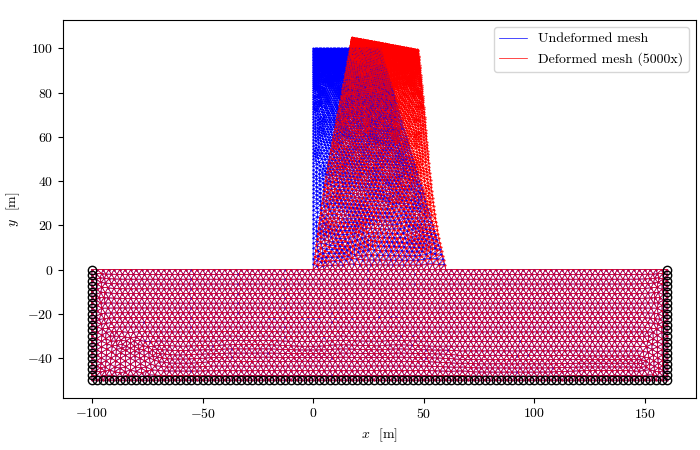

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [182]:
def plot_def_undef_mesh(elements, nodes, disp, xfactor=5, **kwargs):
    figsize = kwargs.get('figsize', [7, 4.5])
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize, layout='constrained')
    # Undeformed mesh
    tri_mesh = pos.mesh2tri(nodes, elements)
    ax.triplot(tri_mesh, marker=".", lw=0.5, ms=1.0, color="b", label='Undeformed mesh')
    # Deformed mesh
    nodes_def = nodes.copy()
    nodes_def[:, 1] += xfactor * disp.T[0]
    nodes_def[:, 2] += xfactor * disp.T[1]
    tri_mesh = pos.mesh2tri(nodes_def, elements)
    ax.triplot(tri_mesh, marker=".", lw=0.5, ms=1, color="r",
               label=f'Deformed mesh ({xfactor}x)')
    # Constraints
    x, y = nodes[:, 1:3].T
    bcx = nodes[:, 3] == -1
    bcy = nodes[:, 4] == -1
    ms=6
    ax.plot(x[bcx]-ms/100, y[bcx], "ok", ms=ms, fillstyle='none')
    ax.plot(x[bcy], y[bcy]-ms/100, "ok", ms=ms, fillstyle='none')
    # Format
    ax.legend(loc='best')
    ax.axis("image")
    ax.set(xlabel='$x$  [m]', ylabel='$y$  [m]')
    plt.show()
    display(wgt.HTML(html_setup))
    plt.close()
    return

plot_def_undef_mesh(elems, nodes, disp, xfactor=int(5e3))


In [183]:
def mesh2tri(nodes, elements, field):
    coord_x = nodes[:, 1]
    coord_y = nodes[:, 2]
    triangs = [elem[3:] for elem in elements]
    mask = np.any(np.isinf(field[triangs]), axis=1)
    mask += np.any(np.isnan(field[triangs]), axis=1)
    tri = mpl.tri.Triangulation(coord_x, coord_y, np.array(triangs), mask)
    return tri

def plot_fields(fields, nodes, elements, titles, cmap="RdYlBu_r", centercbar=True, **kwargs):
    figsize = kwargs.get('figsize')
    fig, axs = plt.subplots(nrows=len(fields), ncols=1, figsize=figsize,
                            sharey=True, sharex=True, layout='constrained')
    if len(fields) == 1:
        axs = list(axs)
    levels = 15
    for ax, field, title, i in zip(axs, fields, titles, range(len(fields))):
        if centercbar:
            vmax = np.nanmax(np.abs(field))
            vmin = -vmax
        else:
            vmin, vmax = None, None
        vmax = np.nanmax(np.abs(field))
        tri_mesh = mesh2tri(nodes, elements, field)
        im = ax.tricontourf(
            tri_mesh, field, levels=levels, cmap=cmap,vmin=vmin, vmax=vmax)#,extend='both')
        ax.axis('image')
        ax.set_title(title)
        ax.set_xlabel('$x$  [m]')
        fig.colorbar(im, ax=ax, shrink=.6, pad=0.05, aspect=10,
                     orientation='vertical')
    axs[0].set_ylabel('$y$  [m]')
    plt.show()
    display(wgt.HTML(html_setup))
    plt.close()
    return


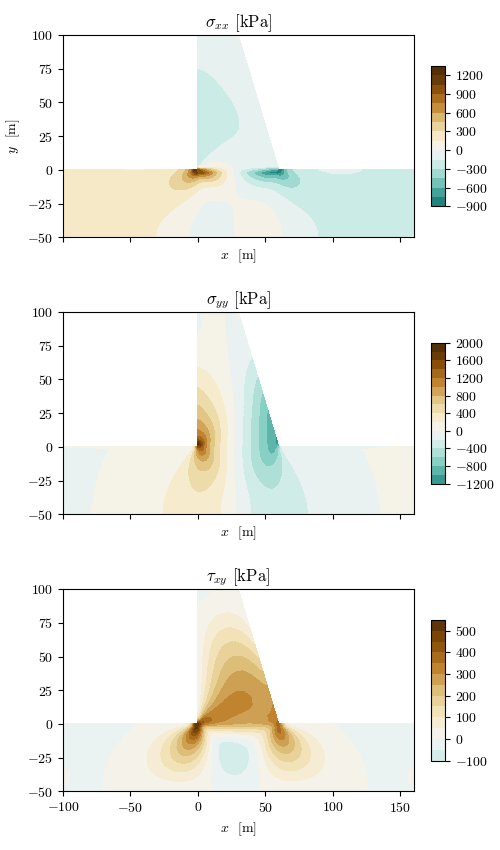

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [184]:
plot_fields(
    fields=(1e-3*fields["𝜎_xx"], 1e-3*fields["𝜎_yy"], 1e-3*fields["𝜏_xy"]),
    nodes=nodes, elements=elems,
    titles=["$\\sigma_{xx}$ [kPa]", "$\\sigma_{yy}$ [kPa]", "$\\tau_{xy}$ [kPa]"],
    figsize=[5, 8.5],
    cmap="BrBG_r",
    cbar=True
)


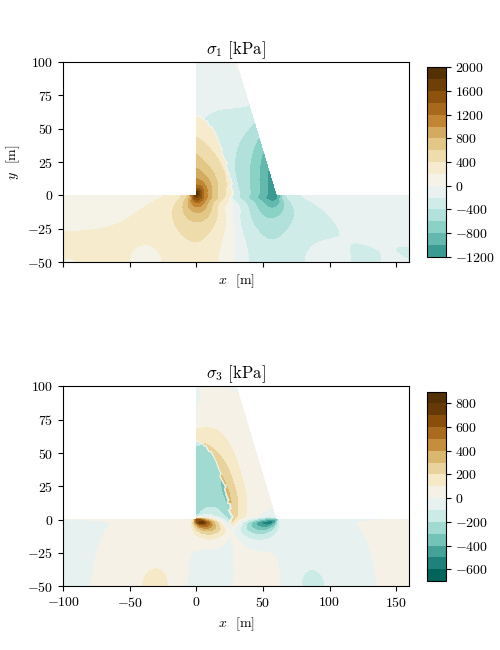

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [185]:
plot_fields(
    fields=(1e-3*fields["𝜎_1"], 1e-3*fields["𝜎_3"]),
    nodes=nodes, elements=elems,
    titles=["$\\sigma_{1}$ [kPa]", "$\\sigma_{3}$ [kPa]"],
    figsize=[5, 6.5],
    cmap="BrBG_r",
    centercbar=True
)


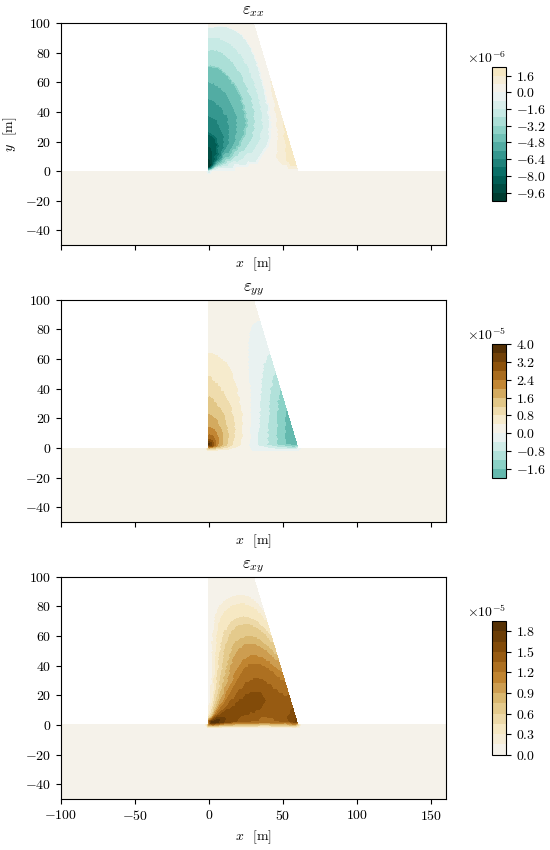

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [186]:
plot_fields(  # Stresses in xx-direction
    fields=(fields["𝜀_xx"], fields["𝜀_yy"], fields["𝛾_xy"]),
    nodes=nodes, elements=elems,
    titles=["$\\varepsilon_{xx}$", "$\\varepsilon_{yy}$", "$\\varepsilon_{xy}$"],
    figsize=[5.5, 8.5],
    cmap="BrBG_r",
    centercbar=True
)


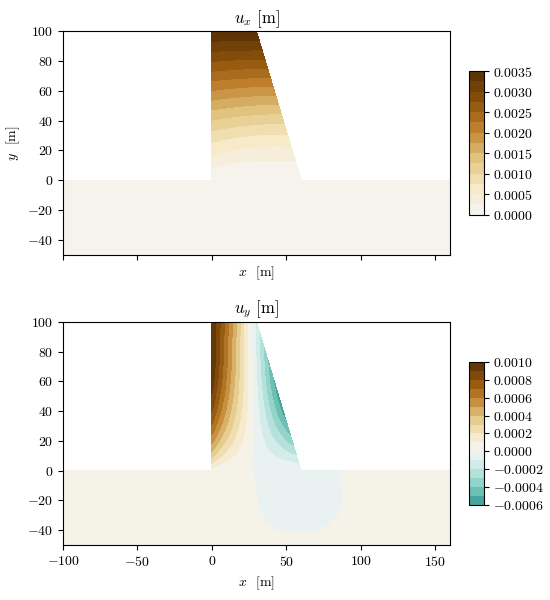

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [187]:
plot_fields(
    fields=(fields["𝑢_x"], fields["𝑢_y"]),
    nodes=nodes, elements=elems,
    titles=["$u_{x}$ [m]", "$u_{y}$ [m]"],
    figsize=[5.5, 6.0],
    cmap="BrBG_r",
    centercbar=True
)
